# 内部和外部细胞边界
在研究组织、生物体和类器官时，细胞及其膜在组织中的位置和方向通常是相关的。例如，我们区分组织内细胞的顶端（位于顶部，末端，外部）和基底（位于底部，内部）侧。从细胞分割标签图像开始，我们可以识别位于由细胞构成的结构外部或内部的像素。在以下示例中，我们使用一个合成的二维图像，展示了一些形成类器官的细胞。这些函数在3D中同样适用。

In [1]:
import numpy as np
import pyclesperanto_prototype as cle

首先，我们构建我们的合成数据集。它由6个细胞中心组成，我们将其膨胀以形成一个类器官。

In [2]:
points = np.asarray([
    [50, 50],
    [60, 60],
    [25, 40],
    [70, 30],
    [35, 65],
    [50, 25]
]).T
image = np.zeros((100, 100))
spots = cle.pointlist_to_labelled_spots(points, image)
cells = cle.dilate_labels(spots, radius=15)
spots.shape

(100, 100)

这些是我们的细胞：

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
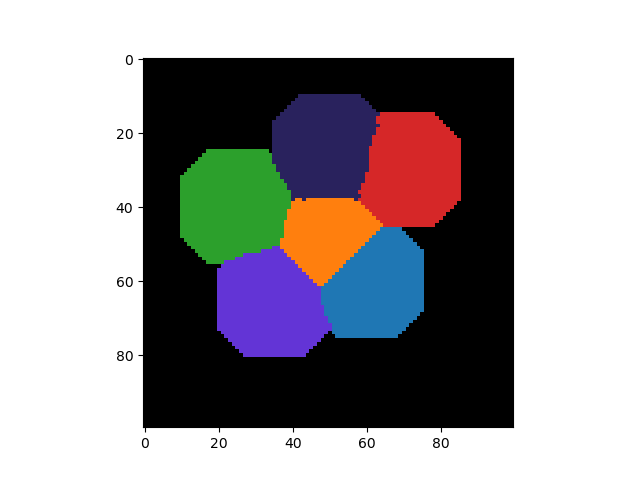

In [3]:
cells

这就是类器官：

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
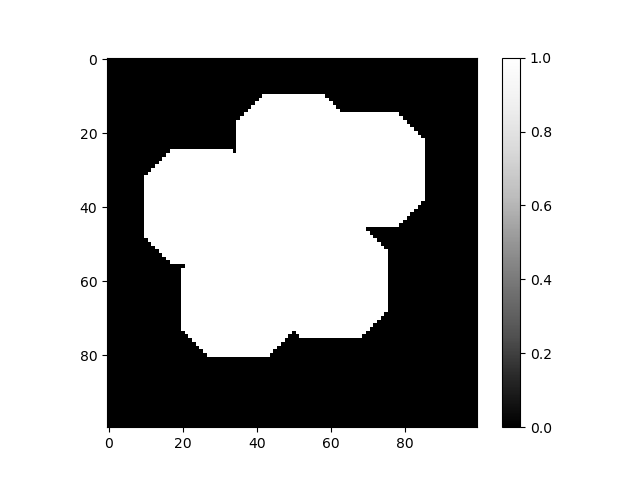
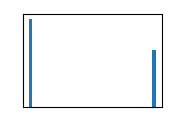

In [4]:
organoid = cells > 0
organoid

现在我们识别位于细胞边界上的像素。

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
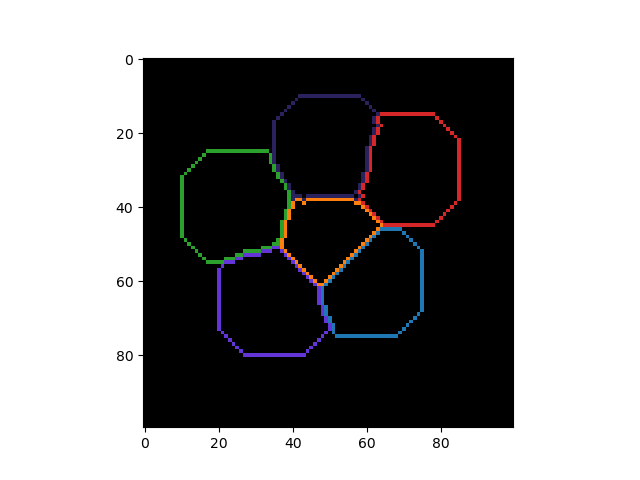

In [5]:
cell_borders = cle.reduce_labels_to_label_edges(cells)
cell_borders

我们可以对类器官执行完全相同的操作，以识别其表面上的像素。

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
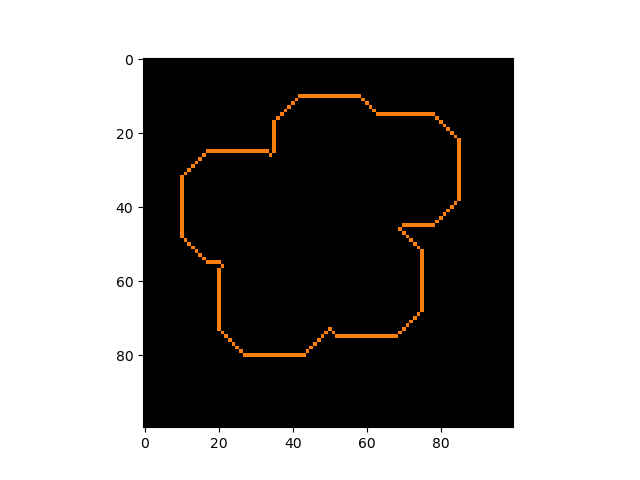

In [6]:
organoid_border = cle.reduce_labels_to_label_edges(organoid)
organoid_border

通过用类器官边界遮罩细胞边界 - 技术上这是一个逐像素乘法 - 我们可以识别外部边界。

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
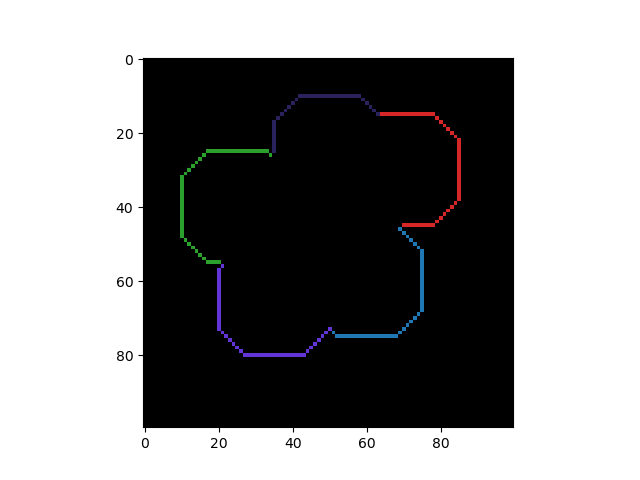

In [7]:
outer_borders = cle.mask(cell_borders, organoid_border).astype(np.uint32)
outer_borders

如果我们从所有细胞边界中减去外部边界，我们就得到内部边界

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
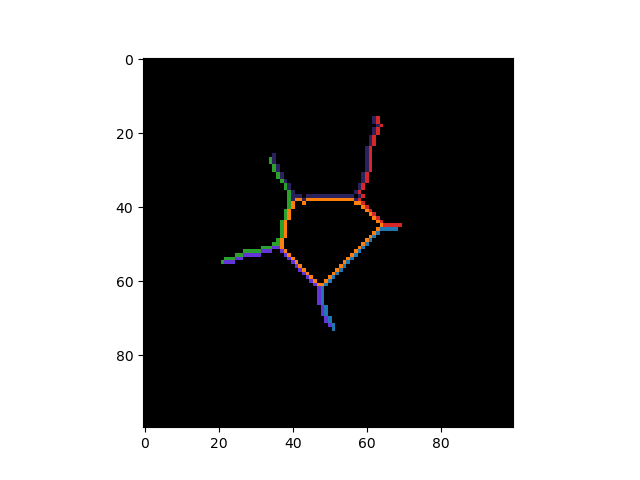

In [8]:
inner_borders = (cell_borders - outer_borders).astype(np.uint32)
inner_borders

在后处理这些标签图像时要小心，因为这些图像可能不是连续标记的。有些库和函数可能在处理这种类型的标签图像时会出现问题（例如 `cle.statistics_of_labelled_pixels()`）。你可以使用 `np.unique()` 打印出标签图像中存在的标签，并可以使用 `cle.relabel_sequential()` 使标签图像连续。

In [9]:
np.unique(outer_borders)

array([0, 2, 3, 4, 5, 6], dtype=uint32)

In [10]:
np.unique(inner_borders)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint32)